## Set-up


In [1]:
# SAM
from sam_helper import *

# Post Processing Helper
from post_helper import *

# Evaluation Function
from evaluation_helper import *


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/susanto/miniforge3/envs/coba_torch/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


B /Users/susanto/Documents/Proyek/best-remove-background/models/InSPyReNet_SwinB_Large.pth
Settings -> Mode=fast, Device=cpu, Torchscript=enabled


In [4]:
import time

import pickle
import datetime


## Example image


In [6]:
file_name_origin = "o_5d53cc84"
image_path = 'AIM500/original/'+file_name_origin+".jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


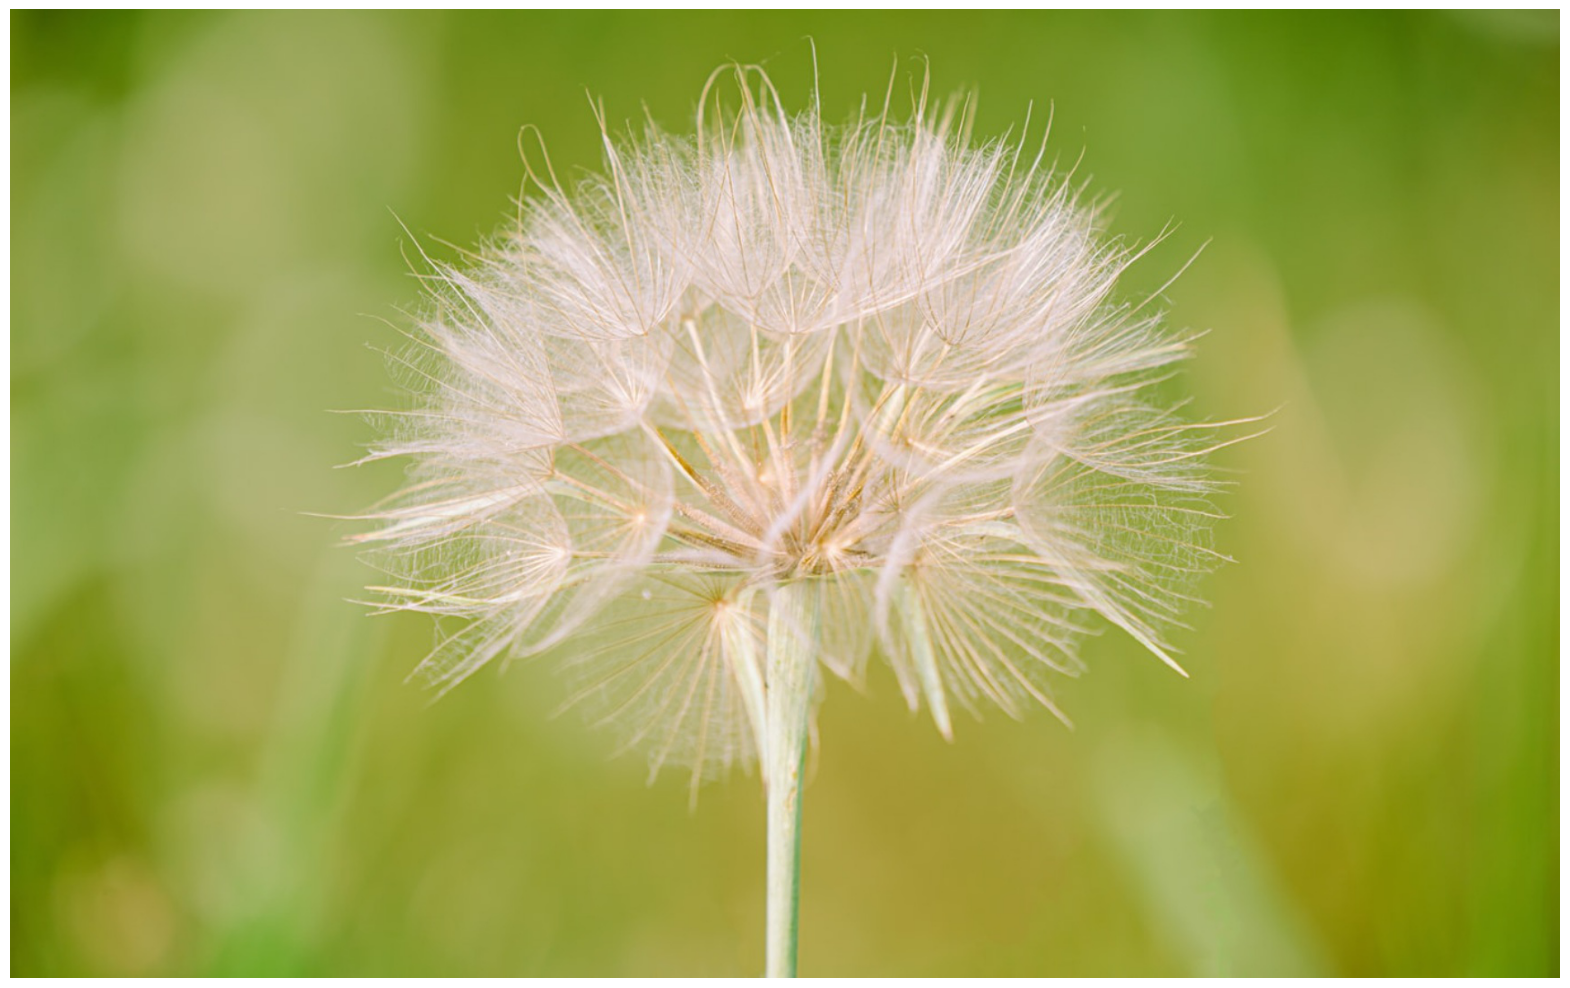

In [7]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()


## Segment Anything Model


In [8]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/Users/susanto/Documents/Proyek/best-remove-background/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)


To generate masks, just run `generate` on an image.


In [9]:
masks = mask_generator.generate(image)


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- `segmentation` : the mask
- `area` : the area of the mask in pixels
- `bbox` : the boundary box of the mask in XYWH format
- `predicted_iou` : the model's own prediction for the quality of the mask
- `point_coords` : the sampled input point that generated this mask
- `stability_score` : an additional measure of mask quality
- `crop_box` : the crop of the image used to generate this mask in XYWH format


In [10]:
print(len(masks))
print(masks[0].keys())


12
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [11]:
# RGB numpy array to RGBA numpy array
rgba_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
rgba_image[:, :, :3] = image
rgba_image[:, :, 3] = 255


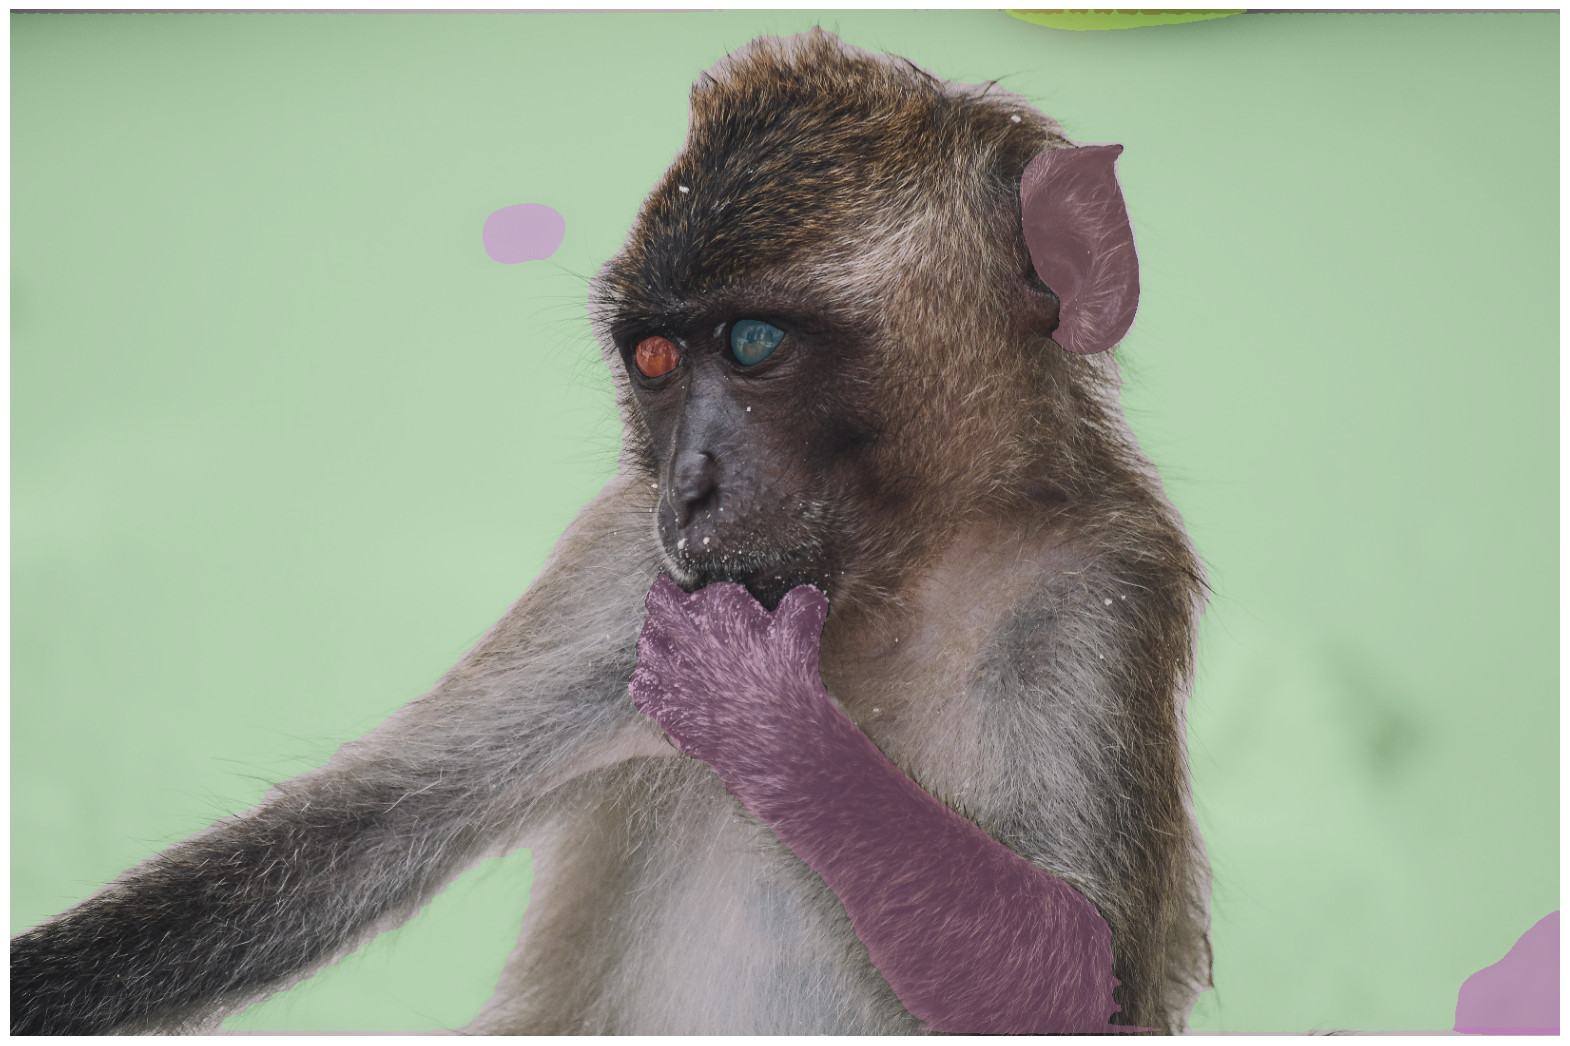

In [59]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()


# Post Processing


SAM -> InSpyRev -> MatteFormer


### InSPyReNet

Revisiting Image Pyramid Structure for High Resolution Salient Object Detection (InSPyReNet)

https://github.com/plemeri/InSPyReNet

https://github.com/plemeri/transparent-background


### Image Matting using MatteFormer

https://github.com/webtoon/matteformer


In [24]:
def rgbToAlpha2D(rgb_gray_scale):
    # # Convert the image to grayscale
    # gray_image = np.mean(rgb_gray_scale, axis=2)

    # # Normalize the pixel values between 0 and 1
    # normalized_image = gray_image / np.max(gray_image)

    # # Scale the values to the desired range (0-255)
    # scaled_image = (normalized_image * 255).astype(np.uint8)

    # return scaled_image
    alpha = np.array(rgb_gray_scale)
    alpha = alpha[:, :, 0] if alpha.ndim > 2 else alpha

    return alpha


In [25]:
def getMSEandSAD(rgba_img, alpha_img):
    # mse = getMSE(rgba_img, alpha_img)
    # sad = getSAD(rgba_img, alpha_img)

    predict = rgba_img[:, :, 3]

    predict = predict / 255
    alpha_img = alpha_img / 255

    sad, mse, mad = calculate_sad_mse_mad_whole_img(predict, alpha_img)
    conn = compute_connectivity_loss_whole_image(predict, alpha_img)
    grad = compute_gradient_whole_image(predict, alpha_img)

    return {
        "sad": sad,
        "mse": mse,
        "mad": mad,
        "conn": conn,
        "grad": grad
    }


In [26]:
def crop_image_with_bounding_box(img, bounding_box):
    x1, y1, x2, y2 = bounding_box
    cropped_image = img[y1:y2, x1:x2,]
    return cropped_image


In [8]:
def getImage(name, folder):
    return np.asarray(Image.open("AIM500/"+folder+"/"+name))


In [9]:
def cropUnusedBlankPixelExtended(myImage):
    # https://stackoverflow.com/a/53829086
    if isinstance(myImage, Image.Image):
        PIL_image = myImage
    else:
        PIL_image = Image.fromarray(myImage.astype('uint8'), 'RGBA')

    bounding = PIL_image.getbbox()

    bounding = extendBoundaries(np.asarray(myImage), bounding, 50)

    if (bounding != None):
        PIL_image = PIL_image.crop(bounding)
    else:
        width, height = PIL_image.size
        bounding = (0, 0, width, height)

    return [PIL_image, np.array(bounding).astype(int)]


In [10]:
def useCache(IDX_IMG, pipeline_name, value=None):
    cache_path = "precompute/"+IDX_IMG+"_"+pipeline_name+".pickle"
    if (value == None):
        if (os.path.exists(cache_path)):
            # Open the pickle file
            with open(cache_path, "rb") as file:
                loaded_dict = pickle.load(file)
            return loaded_dict
        return None
    else:
        # save cache
        # Save the dictionary to the generated filename
        with open(cache_path, "wb") as file:
            pickle.dump(value, file)

    return None


In [11]:
def AIM_Pipeline(IDX_IMG, PIL_image, dilated_sam_mask, croped, blank_image, bounding, origin_alpha, origin_mask):
    cache = useCache(IDX_IMG, "aim")

    if (cache == None):
        start_time = time.time()

        predict = AIMNET_Predictor(np.asarray(PIL_image))

        predict = (predict * 255).astype(np.uint8)

        predict[dilated_sam_mask == False] = 0

        applied_alpha_aim = croped.copy()
        applied_alpha_aim[:, :, 3] = predict

        # back to original size
        a = blank_image.copy()
        alpha_aim_original_size = patchToBoundingBox(
            a, bounding, applied_alpha_aim)

        Image.fromarray(alpha_aim_original_size).save(
            IDX_IMG+"_aim.png")

        # Evaluate SAM before post processing
        AIM_result_origin_size_mask = alpha_aim_original_size[:, :, 3] > 0

        res = getMSEandSAD(alpha_aim_original_size, origin_alpha)
        res["iou"] = getIoU(origin_mask, AIM_result_origin_size_mask)
        res["time"] = time.time() - start_time

        useCache(IDX_IMG, "aim", [predict, res])
    else:
        predict, res = cache

    return predict, res


In [12]:
def Matteformer_Pipeline(IDX_IMG, name_before, JPG_PATH, croped, blank_image, bounding, origin_alpha, origin_mask):
    cache = useCache(IDX_IMG, "matteformer_"+name_before)

    if (cache == None):
        start_time = time.time()

        # Image Matting: MatteFormer
        alpha_pred = image_matting_matte_former(
            JPG_PATH, IDX_IMG+"_trimap_"+name_before+".jpg")

        croped_a = croped.copy()
        croped_a[:, :, 3] = alpha_pred

        # Back to original size
        a = blank_image.copy()
        croped_a = patchToBoundingBox(a, bounding, croped_a)

        Image.fromarray(croped_a).save(
            IDX_IMG+"_"+name_before+"_matteformer.png")

        MatteFormer_result_mask = croped_a[:, :, 3] > 0

        res = getMSEandSAD(croped_a, origin_alpha)
        res["iou"] = getIoU(origin_mask, MatteFormer_result_mask)
        res["time"] = time.time() - start_time

        useCache(IDX_IMG, "matteformer_"+name_before, res)
    else:
        res = cache

    return res


In [13]:
def DIS_Pipeline(IDX_IMG, JPG_PATH, dilated_sam_mask, croped, blank_image, bounding, origin_alpha, origin_mask):
    cache = useCache(IDX_IMG, "dis")

    if (cache == None):
        start_time = time.time()

        mask_dis = getDISMask(JPG_PATH, device="cpu")

        mask_dis[dilated_sam_mask == False] = 0

        DIS_result = croped.copy()
        DIS_result[:, :, 3] = mask_dis

        # Back to original size
        a = blank_image.copy()
        DIS_result_origin_size = patchToBoundingBox(
            a, bounding, DIS_result)

        Image.fromarray(DIS_result_origin_size).save(IDX_IMG+"_dis.png")

        DIS_result_origin_size_mask = DIS_result_origin_size[:, :, 3] > 0

        res = getMSEandSAD(DIS_result_origin_size, origin_alpha)
        res["iou"] = getIoU(origin_mask, DIS_result_origin_size_mask)
        res["time"] = time.time() - start_time

        useCache(IDX_IMG, "dis", [mask_dis, res])
    else:
        mask_dis, res = cache

    return mask_dis, res


In [14]:
def InSpyReNet_Pipeline(IDX_IMG, JPG_PATH, dilated_sam_mask, blank_image, bounding, origin_alpha, origin_mask):
    cache = useCache(IDX_IMG, "InSpyReNet")

    if (cache == None):

        start_time = time.time()
        PIL_image = Image.open(JPG_PATH)
        InSpyReNet_result = remover.process(PIL_image)

        # Remove all region  outside dilated mask
        InSpyReNet_result[dilated_sam_mask == False] = [0, 0, 0, 0]

        # Back to original size
        a = blank_image.copy()
        InSpyReNet_result_origin_size = patchToBoundingBox(
            a, bounding, InSpyReNet_result)

        Image.fromarray(InSpyReNet_result_origin_size).save(
            IDX_IMG+"_InSpy.png")

        InSpyReNet_result_origin_size_mask = InSpyReNet_result_origin_size[:, :, 3] > 0

        res = getMSEandSAD(InSpyReNet_result_origin_size, origin_alpha)
        res["iou"] = getIoU(
            origin_mask, InSpyReNet_result_origin_size_mask)

        res["time"] = time.time() - start_time

        useCache(IDX_IMG, "InSpyReNet", [InSpyReNet_result, res])
    else:
        InSpyReNet_result, res = cache

    return InSpyReNet_result, res


In [15]:
def addTheRestMask(masks):
    mask = masks[0]['segmentation']

    for i in range(0, len(masks)):
        # Apply Segment Mask
        segmentation = masks[i]['segmentation']
        mask = np.logical_or(mask, segmentation)

    inverted_mask = mask ^ True

    masks.append({
        "segmentation": inverted_mask
    })

    return masks


In [16]:
def findSamObjectMaskThatMatchDataset(file_name, masks, threshold=0.5):
    # if the iou between sam and the original is < 0.5
    # it mean sam detect false object from the original object in dataset.
    # then don't do post processing because the dataset AIM-500 is focused on one object in the picture

    file_name_origin = os.path.splitext(file_name)[0]
    maximal = 0
    maximal_index = 0

    # Evaluate ori vs SAM
    origin_img = getImage(file_name_origin+".png", "mask")
    origin_mask = origin_img[:, :,
                             0] > 0 if origin_img.ndim > 2 else origin_img > 0

    for index in range(0, len(masks)):
        sam_mask = masks[index]["segmentation"]

        # Evaluate SAM before post processing
        iou = getIoU(origin_mask, sam_mask)

        if (iou > maximal):
            maximal = iou
            maximal_index = index

    # add more mask if the iou is increased
    basic_mask = masks[maximal_index]["segmentation"]
    current_iou = maximal

    for index in range(0, len(masks)):
        sam_mask = masks[index]["segmentation"]

        result = np.logical_or(sam_mask, basic_mask)

        # Evaluate SAM before post processing
        iou = getIoU(origin_mask, result)

        if (iou > current_iou):
            current_iou = iou
            basic_mask = result

    return basic_mask


In [41]:
def testPostProcessing(file_name, sam_mask):

    # Extract the base name without the extension
    file_name_origin = os.path.splitext(file_name)[0]

    image_path = 'AIM500/original/'+file_name_origin+".jpg"
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # RGB numpy array to RGBA numpy array
    rgba_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
    rgba_image[:, :, :3] = image
    rgba_image[:, :, 3] = 255

    blank_image = np.zeros(
        (rgba_image.shape[0], rgba_image.shape[1], 4), dtype=np.uint8)

    OUTPUT_FOLDER = "output/"

    index = file_name_origin

    evaluation = {
        "sam": 0,

        "InSpyReNet": 0,
        "InSpyReNet_MatteFormer": 0,

        # "DIS": 0,
        # "DIS_MatteFormer": 0,

        "AIM": 0,
        "AIM_MatteFormer": 0,
    }

    # sam_mask = masks[index]["segmentation"]

    IDX_IMG = OUTPUT_FOLDER+str(index)

    applied_mask = rgba_image.copy()
    applied_mask[sam_mask == False] = [0, 0, 0, 0]

    # Crop aplied transparent region (aplied mask)
    [PIL_image, bounding] = cropUnusedBlankPixelExtended(
        Image.fromarray(applied_mask))

    # Crop original image
    croped = crop_image_with_bounding_box(rgba_image.copy(), bounding)

    # Evaluate ori vs SAM
    origin_img = getImage(file_name_origin+".png", "mask")
    origin_alpha = rgbToAlpha2D(origin_img)
    origin_mask = origin_img[:, :,
                             0] > 0 if origin_img.ndim > 2 else origin_img > 0

    # Save origin image
    origin_dataset = rgba_image.copy()
    origin_dataset[:, :, 3] = origin_alpha

    # Evaluate SAM before post processing
    res = getMSEandSAD(applied_mask, origin_alpha)
    res["iou"] = getIoU(origin_mask, sam_mask)
    evaluation["sam"] = res

    Image.fromarray(origin_dataset).save(IDX_IMG+"_origin_dataset.png")
    PIL_image = Image.fromarray(applied_mask)
    PIL_image.save(IDX_IMG+"_origin_sam_applied.png")
    # PIL_image.save(IDX_IMG+"_origin_mask.png")

    # Save original mask
    saveMask(sam_mask, str(index)+"_sam.jpg")

    # Croped original image to JPG for input AIM and  InSpyReNet
    JPG_PATH = IDX_IMG+"_origin.jpg"
    PIL_image = Image.fromarray(croped)
    PIL_image = PIL_image.convert("RGB")
    PIL_image.save(JPG_PATH)

    # POST PROCESSING PIPELINE
    # Remove all region  outside dilated mask
    cropped_mask = cropToBoundingBox(sam_mask, bounding)
    dilated_sam_mask = binary_dilation(cropped_mask)

    # AIM NET _________________________________________
    predict, res = AIM_Pipeline(
        IDX_IMG, PIL_image, dilated_sam_mask, croped, blank_image, bounding, origin_alpha, origin_mask)

    evaluation["AIM"] = res

    if (not os.path.exists(IDX_IMG+"_trimap_aim.jpg")):
        trimap = np.zeros_like(predict)
        trimap[predict == 0] = 0  # Background
        trimap[predict == 255] = 255  # Foreground
        trimap[(predict > 0) & (predict < 255)] = 128  # Unknown region

        Image.fromarray(trimap).save(IDX_IMG+"_trimap_aim.jpg")

    res = Matteformer_Pipeline(
        IDX_IMG, "aim", JPG_PATH, croped, blank_image, bounding, origin_alpha, origin_mask)

    evaluation["AIM_MatteFormer"] = res

    # Dichotomous Image Segmentation ______________________

    # DIS
    # predict, res = DIS_Pipeline(
    #     IDX_IMG, JPG_PATH, dilated_sam_mask, croped, blank_image, bounding, origin_alpha, origin_mask)

    # evaluation["DIS"] = res

    # DIS_result = croped.copy()
    # DIS_result[:, :, 3] = predict

    # # Trimap
    # if (not os.path.exists(IDX_IMG+"_trimap_dis.jpg")):
    #     trimap = makeTrimap(DIS_result)
    #     Image.fromarray(trimap).save(IDX_IMG+"_trimap_dis.jpg")

    # # Matteformer
    # res = Matteformer_Pipeline(
    #     IDX_IMG, "dis", JPG_PATH, croped, blank_image, bounding, origin_alpha, origin_mask)
    # evaluation["DIS_MatteFormer"] = res

    # Dichotomous Image Segmentation ______________________

    # InSpyReNet
    InSpyReNet_result, res = InSpyReNet_Pipeline(
        IDX_IMG, JPG_PATH, dilated_sam_mask, blank_image, bounding, origin_alpha, origin_mask)

    evaluation["InSpyReNet"] = res

    # Image Matting Process _______________________________

    # Trimap
    if (not os.path.exists(IDX_IMG+"_trimap_InSpyReNet.jpg")):
        trimap = makeTrimap(InSpyReNet_result)
        Image.fromarray(trimap).save(IDX_IMG+"_trimap_InSpyReNet.jpg")

    res = Matteformer_Pipeline(
        IDX_IMG, "InSpyReNet", JPG_PATH, croped, blank_image, bounding, origin_alpha, origin_mask)
    evaluation["InSpyReNet_MatteFormer"] = res

    return evaluation


In [42]:
# arrEval = testPostProcessing(file_name_origin, masks[0])


In [43]:
def formatEvaluation(arrEval):
    for i in range(0, len(arrEval)):
        print("Eval ", i)
        for key, value in arrEval[i].items():
            print(key, end=" | ")

            # Check if variable is an integer
            if isinstance(value, int):
                print("No value")
            else:
                for ev, v in value.items():
                    formatted_number = "{:.3f}".format(v)
                    print(ev + ':', formatted_number, end=" | ")

            print("\n")

        print("\n\n\n")


In [20]:
# ORIGINAL_PATH = "AIM500/original"
# img_list = listdir_nohidden(ORIGINAL_PATH)

# # print(img_list)

# arrEval = []

# for i in range(0, len(img_list)):

#     file_name = img_list[i]

#     if (os.path.exists("sam_mask/"+file_name) == False):
#         file_name_origin = os.path.splitext(file_name)[0]

#         image_path = 'AIM500/original/'+file_name_origin+".jpg"
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         masks = mask_generator.generate(image)

#         masks = addTheRestMask(masks)

#         mask = findSamObjectMaskThatMatchDataset(file_name, masks)

#         if isinstance(mask, np.ndarray):
#             # print("testPostProcessing")
#             image_wb = np.uint8(mask) * 255

#             cv2.imwrite("sam_mask/"+file_name, image_wb)

#             # res = testPostProcessing(file_name, mask)

#             # arrEval.append(res)


In [21]:
# # Remove all region  outside dilated mask
# dilated_mask = binary_dilation(cropped_mask)

# plt.imshow(dilated_mask)

# croped[dilated_mask == False] = [0, 0, 0, 0]

# Image.fromarray(croped).save("output/"+str(index)+"_final.png")


## Evaluation


Dalam folder AIM-500

- mask : manual select alpha channel
- orignal : orignal jpg image
- trimap: trimap
- usr: seperti trimap


In [47]:
arrEval = []


In [48]:
ORIGINAL_PATH = "sam_mask"
img_list = os.listdir(ORIGINAL_PATH)
# print(img_list)

for i in range(0, 50):
    file_name = img_list[i]
    file_name_origin = os.path.splitext(file_name)[0]

    # if (os.path.exists("output/"+file_name_origin+"_origin_dataset.png") == False):
    PIL_image = Image.open(ORIGINAL_PATH+"/"+file_name)

    mask_np = np.asarray(PIL_image)

    mask = mask_np > 0

    res = testPostProcessing(file_name, mask)

    arrEval.append(res)


In [30]:
formatEvaluation(arrEval)


Eval  0
sam | sad: 75.281 | mse: 0.030 | mad: 0.036 | conn: 76.616 | grad: 142.766 | iou: 0.895 | 

InSpyReNet | sad: 41.405 | mse: 0.009 | mad: 0.020 | conn: 39.199 | grad: 48.499 | iou: 0.911 | time: 4.613 | 

InSpyReNet_MatteFormer | sad: 15.046 | mse: 0.002 | mad: 0.007 | conn: 13.022 | grad: 13.441 | iou: 0.932 | time: 14.838 | 

DIS | sad: 327.424 | mse: 0.138 | mad: 0.158 | conn: 334.966 | grad: 36.250 | iou: 0.732 | time: 5.954 | 

DIS_MatteFormer | sad: 356.614 | mse: 0.159 | mad: 0.172 | conn: 358.424 | grad: 32.284 | iou: 0.409 | time: 15.805 | 

AIM | sad: 27.457 | mse: 0.006 | mad: 0.013 | conn: 25.108 | grad: 45.445 | iou: 0.912 | time: 10.736 | 

AIM_MatteFormer | sad: 21.640 | mse: 0.005 | mad: 0.010 | conn: 19.211 | grad: 33.486 | iou: 0.912 | time: 15.467 | 





Eval  1
sam | sad: 75.281 | mse: 0.030 | mad: 0.036 | conn: 76.616 | grad: 142.766 | iou: 0.895 | 

InSpyReNet | sad: 41.405 | mse: 0.009 | mad: 0.020 | conn: 39.199 | grad: 48.499 | iou: 0.911 | time: 4.613 

In [34]:
def saveEvalResult(my_dict):
    # Get the current date, hour, and minute
    current_time = datetime.datetime.now()
    formatted_time = current_time.strftime("%Y-%m-%d_%H-%M")

    # Generate the filename with date, hour, and minute
    filename = f"eval_result_{formatted_time}.pickle"

    # Save the dictionary to the generated filename
    with open("evaluations/"+filename, "wb") as file:
        pickle.dump(my_dict, file)


In [35]:
def openEvalResult(file_name):
    # Open the pickle file
    with open(file_name, "rb") as file:
        loaded_dict = pickle.load(file)

    return loaded_dict


In [36]:
def printEvaluation(sum_dict):
    for key, value in sum_dict.items():
        if isinstance(value, int):
            print("Evaluation from ", value, " data")
        else:
            print(key, end=" | ")
            for ky, val in value.items():
                formatted_number = "{:.3f}".format(sum_dict[key][ky])
                print(ky + ':', formatted_number, end=" | ")

        print("\n")


In [37]:
def formatEvaluationMean(arrEval):
    length = len(arrEval)
    # Get all key
    sum_dict = {
        "length": length
    }

    for i in range(0, 1):
        for key, value in arrEval[i].items():
            sum_dict[key] = {
                "sad": 0,
                "mse": 0,
                "mad": 0,
                "conn": 0,
                "grad": 0,
                "iou": 0,
                "time": 0
            }

    # print(sum_dict)

    for i in range(0, len(arrEval)):
        for key, value in arrEval[i].items():
            # Check if variable is an integer
            if not isinstance(value, int):
                for ev, v in value.items():
                    sum_dict[key][ev] = sum_dict[key][ev]+v

    # print(sum_dict)
    for key, value in sum_dict.items():
        if not isinstance(value, int):
            for ky, val in value.items():
                sum_dict[key][ky] = sum_dict[key][ky]/length

    # print(sum_dict)
    # print("Evaluation from ", length, " data")

    # PRINT
    printEvaluation(sum_dict)

    # saveEvalResult(sum_dict)
    return sum_dict


In [50]:
sum_dict = formatEvaluationMean(arrEval)

saveEvalResult(sum_dict)


Evaluation from  50  data


sam | sad: 59.066 | mse: 0.032 | mad: 0.036 | conn: 60.011 | grad: 71.261 | iou: 0.925 | time: 0.000 | 

InSpyReNet | sad: 28.551 | mse: 0.008 | mad: 0.017 | conn: 25.253 | grad: 68.858 | iou: 0.911 | time: 2.801 | 

InSpyReNet_MatteFormer | sad: 23.631 | mse: 0.008 | mad: 0.014 | conn: 22.916 | grad: 35.215 | iou: 0.917 | time: 7.624 | 

AIM | sad: 35.866 | mse: 0.016 | mad: 0.021 | conn: 27.898 | grad: 34.076 | iou: 0.882 | time: 3.557 | 

AIM_MatteFormer | sad: 45.488 | mse: 0.022 | mad: 0.027 | conn: 37.850 | grad: 42.588 | iou: 0.873 | time: 7.761 | 



In [39]:
a = openEvalResult("evaluations/eval_result_2023-05-29_19-09.pickle")

print(a)

printEvaluation(a)


{'length': 20, 'sam': {'sad': 114.54391882352945, 'mse': 0.06548240430927829, 'mad': 0.07149470701255903, 'conn': 116.80625716126156, 'grad': 87.15476600646971, 'iou': 0.9071147732499487, 'time': 0.0}, 'InSpyReNet': {'sad': 32.46298411764705, 'mse': 0.008737918759815529, 'mad': 0.019300322047195777, 'conn': 28.667675468888696, 'grad': 61.56700531005858, 'iou': 0.8689068662249457, 'time': 3.905256152153015}, 'InSpyReNet_MatteFormer': {'sad': 26.79763764705882, 'mse': 0.008057810898237103, 'mad': 0.016167234356932007, 'conn': 25.25078175429662, 'grad': 29.98962966918945, 'iou': 0.8733951589580382, 'time': 11.133978986740113}, 'DIS': {'sad': 129.71566529411766, 'mse': 0.06142489897726604, 'mad': 0.0742860628353295, 'conn': 130.4692069326586, 'grad': 46.62171615600586, 'iou': 0.8113825495506519, 'time': 5.712354755401611}, 'DIS_MatteFormer': {'sad': 145.80970784313726, 'mse': 0.07377472431034796, 'mad': 0.0836526100513559, 'conn': 145.24209744920466, 'grad': 56.362632522583, 'iou': 0.71072